# 目录
1. [数据下载与导入](#数据下载与导入)
2. [数据预处理](#数据预处理)
3. [超参数设置](#超参数设置)
4. [辅助函数定义](#辅助函数定义)
5. [自定义数据集](#自定义数据集)
6. [TextCNN模型构建](#textcnn模型构建)
7. [模型训练与评估](#模型训练与评估)
8. [单条文本预测](#单条文本预测)


# 数据下载

In [1]:
# !kaggle datasets download scodepy/customer-support-intent-dataset

!curl -L -o customer-support-intent-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/scodepy/customer-support-intent-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 61400  100 61400    0     0    98k      0 --:--:-- --:--:-- --:--:--   98k


In [2]:
!unzip /content/customer-support-intent-dataset.zip

Archive:  /content/customer-support-intent-dataset.zip
  inflating: Bitext_Sample_Customer_Service_Testing_Dataset.csv  
  inflating: Bitext_Sample_Customer_Service_Training_Dataset.csv  
  inflating: Bitext_Sample_Customer_Service_Validation_Dataset.csv  


# 导入python包

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 准备数据集

**第一步：加载训练数据**
- `pd.read_csv()` 读取CSV文件
- `.sample(frac=1)` 随机打乱数据顺序（防止数据有序排列影响训练）
- `reset_index(drop=True)` 重置索引

**第二步：探索数据特征**
- `pd_data.shape` 查看数据维度
- `category.value_counts()` 统计各类别数量分布
- 添加文本长度特征，了解客户问询的长度分布

**第三步：标签编码**
- `LabelEncoder()` 将文本类别转换为数字标签
- 比如："账户问题"→0，"密码重置"→1，"退款申请"→2
- 神经网络只认识数字，不认识文字哦！

**第四步：加载测试数据**
- 用同样的标签编码器处理测试集
- 保证训练集和测试集的标签对应关系一致

In [4]:
pd_data = pd.read_csv('/content/Bitext_Sample_Customer_Service_Testing_Dataset.csv').sample(frac=1).reset_index(drop=True)
pd_data.head()

,utterance,intent,category,tags
0,I have to submit some feedback for your company,review,FEEDBACK,B
1,how to check when my item is going to arrive?,delivery_period,DELIVERY,BI
2,I need assistance to remove an item,change_order,ORDER,B
3,could you help me reporting registration issues?,registration_problems,ACCOUNT,BIMP
4,what do I have to do to buy something?,place_order,ORDER,BI


In [5]:
pd_data.shape

(818, 4)

In [6]:
pd_data['category'].value_counts()

,count
category,
ACCOUNT,172
ORDER,125
REFUND,93
SHIPPING_ADDRESS,73
DELIVERY,70
CONTACT,66
INVOICE,62
FEEDBACK,55
PAYMENT,53


In [7]:
def get_len(item):
  return len(item.split(' '))

pd_data['len'] = pd_data['utterance'].astype('str').map(get_len)
pd_data.head()

,utterance,intent,category,tags,len
0,I have to submit some feedback for your company,review,FEEDBACK,B,9
1,how to check when my item is going to arrive?,delivery_period,DELIVERY,BI,10
2,I need assistance to remove an item,change_order,ORDER,B,7
3,could you help me reporting registration issues?,registration_problems,ACCOUNT,BIMP,7
4,what do I have to do to buy something?,place_order,ORDER,BI,9


In [8]:
le = LabelEncoder()
pd_data['label'] = le.fit_transform(pd_data['category'])
print(pd_data.shape)
pd_data.head()


(818, 6)


,utterance,intent,category,tags,len,label
0,I have to submit some feedback for your company,review,FEEDBACK,B,9,4
1,how to check when my item is going to arrive?,delivery_period,DELIVERY,BI,10,3
2,I need assistance to remove an item,change_order,ORDER,B,7,7
3,could you help me reporting registration issues?,registration_problems,ACCOUNT,BIMP,7,0
4,what do I have to do to buy something?,place_order,ORDER,BI,9,7


In [9]:
name_list = le.classes_
name_list

array(['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK',
       'INVOICE', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUND',
       'SHIPPING_ADDRESS'], dtype=object)

In [10]:
pd_test = pd.read_csv('/content/Bitext_Sample_Customer_Service_Validation_Dataset.csv')
print(pd_test.shape)
pd_test.head()

(818, 4)


,utterance,intent,category,tags
0,I want help to cancel the order I have made,cancel_order,ORDER,B
1,where can I get information about order cancel...,cancel_order,ORDER,BIM
2,help to cancel the last order,cancel_order,ORDER,B
3,I need help with canceling an order I made,cancel_order,ORDER,B
4,I do not know how I can cancel the order I made,cancel_order,ORDER,BE


In [11]:
pd_test['label'] = le.transform(pd_test['category'])
pd_test.head()

,utterance,intent,category,tags,label
0,I want help to cancel the order I have made,cancel_order,ORDER,B,7
1,where can I get information about order cancel...,cancel_order,ORDER,BIM,7
2,help to cancel the last order,cancel_order,ORDER,B,7
3,I need help with canceling an order I made,cancel_order,ORDER,B,7
4,I do not know how I can cancel the order I made,cancel_order,ORDER,BE,7


In [12]:
le.classes_, len(le.classes_)

(array(['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK',
        'INVOICE', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUND',
        'SHIPPING_ADDRESS'], dtype=object),
 11)

<Axes: >

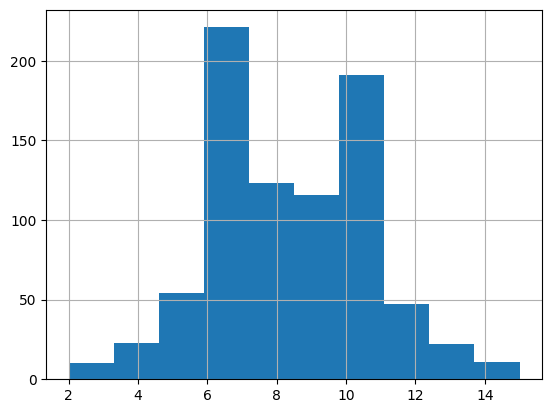

In [13]:
pd_data['len'].hist()

# 超参数设置

**🎯 超参数解释：**
- `max_len = 25`：每个句子最大长度，超过截断，不足补零
- `n_class = 11`：一共11种客户意图类别
- 使用BERT的分词器处理文本，但模型用自己的TextCNN
- `voc_size`：词汇表大小，决定词嵌入层的输入维度

In [14]:
max_len = 25
n_class = 11

In [15]:
name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(name)
# model = AutoModelForSequenceClassification.from_pretrained(name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 准备tokenizer和模型

In [16]:
tokenizer.vocab

{'asshole': 22052,
 '##room': 9954,
 'prolific': 12807,
 'mont': 18318,
 'nails': 10063,
 'more': 2062,
 '##lden': 28476,
 'grains': 17588,
 'moffat': 28528,
 'obscured': 23649,
 'reportedly': 7283,
 'season': 2161,
 'finley': 29194,
 'nos': 16839,
 'unaware': 11499,
 'ambassadors': 20986,
 'tomatoes': 12851,
 'become': 2468,
 'landings': 16805,
 'high': 2152,
 'semifinals': 8565,
 'aquarium': 18257,
 'brothers': 3428,
 'comparatively': 20172,
 'expo': 16258,
 'accomplish': 14570,
 'och': 28166,
 '##zzi': 13793,
 'waivers': 28654,
 'adaptive': 19293,
 'poised': 22303,
 'corbin': 24003,
 'module': 11336,
 '##⁸': 30077,
 'separate': 3584,
 'sargent': 27599,
 '##ulata': 18060,
 'sparks': 12300,
 '##و': 29836,
 'ventilation': 19536,
 '##ford': 3877,
 '##cy': 5666,
 'mario': 7986,
 'thrilled': 16082,
 'bing': 17620,
 'outer': 6058,
 'impressive': 8052,
 'jackie': 9901,
 '##ill': 8591,
 '1726': 28342,
 'card': 4003,
 'europa': 12124,
 'nicholas': 6141,
 '##water': 5880,
 'bo': 8945,
 'patien

In [17]:
voc_size = len(tokenizer.vocab)
voc_size

30522

# 相关函数

## 可视化训练过程 模型训练测试

**🛠️ 辅助函数解析：**

**1. `plot_acc_loss()` - 训练过程可视化**
- 画出训练和验证的准确率、损失变化曲线
- 帮你判断模型是否过拟合或欠拟合
- 两条线贴得很近=训练良好，差距很大=可能过拟合

**2. `get_predict_score()` - 获取预测结果**
- 模型预测所有测试数据
- 返回预测概率、预测标签和真实标签
- 用于后续的性能评估

**3. `train_test_epoch()` - 训练主循环**
- 控制整个训练过程
- 每个epoch都训练一次，测试一次
- 记录每轮的损失和准确率

**4. `train()` - 单次训练**
- 前向传播：数据→模型→预测
- 计算损失：预测vs真实标签
- 反向传播：更新模型参数
- 就像学生做题→对答案→总结错误→提高水平

**5. `test()` - 单次测试**
- 模型进入评估模式
- 不更新参数，只计算准确率
- 相当于考试，检验学习效果

In [18]:

def plot_acc_loss(train_acc_list,test_acc_list,train_loss_list,test_loss_list):
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
    acc = train_acc_list
    val_acc = test_acc_list

    loss = train_loss_list
    val_loss = test_loss_list
    epochs_range = range(epochs)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def get_predict_score(model, test_dl):
    predict_list = []
    label_list = []
    predict_pro_list = []
    m_softmax = nn.Softmax(dim=1)
    model.eval()
    for (b_text, y) in test_dl:
        b_text, y = b_text.to(device), y.to(device)

        predict_score = model(b_text)
        predict_pro = m_softmax(predict_score)
        predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

        predict_pro_list.append(predict_pro.detach().cpu().numpy())
        predict_list.append(predict_label)
        label_list.append(y.detach().cpu().numpy())

    predict_pro_array = np.vstack(predict_pro_list)[:,1]
    predict_array = np.hstack(predict_list)
    label_array = np.hstack(label_list)
    # predict_pro_array[:5],predict_array[:5],label_array[:5]
    return predict_pro_array,predict_array,label_array


def train_test_epoch(train_dl,test_dl, model, loss_fn, optimizer,epochs):
    # epochs = 2
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dl, model, loss_fn, optimizer)

        train_loss, train_correct = test(train_dl, model, loss_fn)
        test_loss, test_correct = test(test_dl, model, loss_fn)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_correct)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_correct)

    print("Done!")
    return train_loss_list,train_acc_list,test_loss_list,test_acc_list

## 准备训练和测试循环

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y) in dataloader:
            X = X.to(device)

            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

# 数据处理pipline

## 英文编码

In [20]:
text_eg = 'i feel good'

inputs = tokenizer(text_eg, padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 1045, 2514, 2204,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]])}

## 自定义dataset

In [21]:
pd_data.head()

,utterance,intent,category,tags,len,label
0,I have to submit some feedback for your company,review,FEEDBACK,B,9,4
1,how to check when my item is going to arrive?,delivery_period,DELIVERY,BI,10,3
2,I need assistance to remove an item,change_order,ORDER,B,7,7
3,could you help me reporting registration issues?,registration_problems,ACCOUNT,BIMP,7,0
4,what do I have to do to buy something?,place_order,ORDER,BI,9,7


In [22]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.nn import  functional as F

class CustomDataset(Dataset):
    def __init__(self, pd_data,tokenizer):
        self.pd_data = pd_data
        self.text_list = list(pd_data['utterance'].astype('str'))
        self.label_list = list(pd_data['label'])
        self.tokenizer = tokenizer

    def __len__(self):
        # return len(self.label_list)
        return len(self.pd_data)

    def __getitem__(self, idx):
        one_text = self.text_list[idx]
        # print(one_text)
        one_result = self.tokenizer(one_text,padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")
        # print(one_result)
        one_ids = one_result.input_ids[0]
        one_attention_mask = one_result.attention_mask

        one_label = self.label_list[idx]
        one_label = torch.tensor(one_label).long()
        return one_ids, one_label

In [23]:
train_ds = CustomDataset(pd_data,tokenizer)
test_ds = CustomDataset(pd_test,tokenizer)

In [24]:
# all_ds = CustomDataset(pd_data,tokenizer)
# # _, train_ds, test_ds = torch.utils.data.random_split(all_ds, [0.98,0.016, 0.004])
# train_ds, test_ds = torch.utils.data.random_split(all_ds, [0.8,0.2])
train_ds[1],len(train_ds),len(test_ds)

((tensor([ 101, 2129, 2000, 4638, 2043, 2026, 8875, 2003, 2183, 2000, 7180, 1029,
           102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0]),
  tensor(3)),
 818,
 818)

## 准备dataloader

In [25]:

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8)

In [26]:
# for text_b,label in test_dl:
for text_b,label in train_dl:
  print(text_b.shape)
  print(label)
  break

torch.Size([8, 25])
tensor([3, 5, 2, 4, 0, 7, 3, 2])


**📦 自定义数据集详解：**

**CustomDataset类的作用：**
- 继承PyTorch的Dataset基类
- 把pandas数据框转换为PyTorch能处理的格式
- 就像把食材准备好，方便批量下锅

**核心方法解析：**
1. `__init__()` - 初始化
   - 保存数据和分词器
   - 提取文本和标签列表

2. `__len__()` - 返回数据集大小
   - PyTorch需要知道有多少条数据

3. `__getitem__()` - 获取单条数据
   - 对文本进行tokenize（分词+编码）
   - padding到统一长度，truncation截断过长文本
   - 返回编码后的文本和对应标签

**DataLoader的作用：**
- `batch_size=8`：每次喂给模型8条数据
- `shuffle=True`：训练时随机打乱数据顺序
- 就像食堂打饭，一次盛一勺，但每次勺子里的菜都不一样

# 确定GPU cpu使用情况

In [27]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# textcnn 模型

## 构建模型

In [28]:
class textCNN(nn.Module):
    def __init__(self,):
        super().__init__()
        emb_dim = 100
        # n_class = 4
        kernels=[3,4,5]
        kernel_number=[150,150,150]
        self.embd = nn.Embedding(voc_size, emb_dim)
        self.convs = nn.ModuleList([nn.Conv1d(max_len, number, size,padding=size) for (size,number) in zip(kernels,kernel_number)])
        self.dropout=nn.Dropout(0.1)
        self.lin = nn.Linear(sum(kernel_number), 50)
        self.out = nn.Linear(50, n_class)

    def forward(self, x):
        x = self.embd(x)

        x = [F.relu(conv(x)) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.lin(x)

        x = self.out(x)
        return x
text_cnn = textCNN().to(device)

text_cnn(text_b.to(device)).shape

torch.Size([8, 11])


**模型架构：**
```
输入文本 → 词嵌入 → 多种卷积核 → 最大池化 → 拼接 → 全连接 → 分类输出
```

**各层详细解析：**

**1. 词嵌入层 (Embedding)**
- `nn.Embedding(voc_size, emb_dim)`
- 把词汇ID转换为100维的向量
- 就像给每个词分配一个100维的身份证

**2. 卷积层 (Convolutions)**
- `kernels=[3,4,5]`：使用3种不同大小的卷积核
- 3-gram：捕获3个词的组合特征
- 4-gram：捕获4个词的组合特征  
- 5-gram：捕获5个词的组合特征
- 就像用不同大小的滤镜看文本，发现不同的模式

**3. 最大池化 (Max Pooling)**
- 从每个特征图中选出最重要的特征
- 降低维度，保留关键信息
- 相当于从一堆照片中挑出最好看的

**4. 特征拼接**
- `torch.cat(x, 1)`：把不同卷积核的结果拼接
- 450维特征向量 (150+150+150)

**5. 全连接层**
- `nn.Linear(450, 50)`：压缩到50维
- `nn.Linear(50, 11)`：输出11个类别的分数
- Dropout防止过拟合

**为什么TextCNN适合文本分类？**
- 卷积操作能捕获n-gram特征
- 多种卷积核size捕获不同长度的语言模式
- 池化操作提取最重要的特征
- 比RNN更快，比传统方法更准确


## 准备损失函数和优化器

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_cnn.parameters(), lr=1e-3)

## 训练和评估

**训练过程：**
- `epochs=10`：数据集过10遍
- 每个epoch训练一轮，测试一轮
- 记录损失和准确率的变化


In [30]:


epochs = 10
train_loss_list,train_acc_list,test_loss_list,test_acc_list = train_test_epoch(train_dl, test_dl, text_cnn, loss_fn, optimizer,epochs)
train_loss_list,train_acc_list,test_loss_list,test_acc_list

Epoch 1
-------------------------------
loss: 2.236016  [    8/  818]
loss: 2.255673  [  408/  818]
loss: 2.269344  [  808/  818]
Test Error: 
 Accuracy: 22.9%, Avg loss: 2.211410 

Test Error: 
 Accuracy: 24.1%, Avg loss: 2.300070 

Epoch 2
-------------------------------
loss: 2.247718  [    8/  818]
loss: 2.228695  [  408/  818]
loss: 2.154701  [  808/  818]
Test Error: 
 Accuracy: 24.3%, Avg loss: 2.099992 

Test Error: 
 Accuracy: 20.5%, Avg loss: 2.234817 

Epoch 3
-------------------------------
loss: 2.208812  [    8/  818]
loss: 2.217318  [  408/  818]
loss: 1.725269  [  808/  818]
Test Error: 
 Accuracy: 33.3%, Avg loss: 1.842685 

Test Error: 
 Accuracy: 30.2%, Avg loss: 2.027051 

Epoch 4
-------------------------------
loss: 1.952855  [    8/  818]
loss: 1.415992  [  408/  818]
loss: 1.730843  [  808/  818]
Test Error: 
 Accuracy: 36.4%, Avg loss: 1.601487 

Test Error: 
 Accuracy: 25.4%, Avg loss: 1.959685 

Epoch 5
-------------------------------
loss: 1.760726  [    8/ 

([2.2114095352228405,
  2.0999921953793868,
  1.8426846057465933,
  1.601487226856565,
  1.1721383009142088,
  1.0792610833367098,
  0.7319519576227781,
  0.565110114665286,
  0.3219537867721423,
  0.267227069682722],
 [0.22860635696821516,
  0.24327628361858192,
  0.33251833740831294,
  0.3643031784841076,
  0.793398533007335,
  0.6638141809290954,
  0.7860635696821516,
  0.8361858190709046,
  0.9193154034229829,
  0.910757946210269],
 [2.300069744147143,
  2.2348170095277062,
  2.027051208667385,
  1.9596845542342918,
  1.5733147726475614,
  1.5952838562356615,
  1.3004159885413438,
  1.2403386691856442,
  0.9712825369596192,
  0.8945799088919336],
 [0.24083129584352078,
  0.20537897310513448,
  0.3019559902200489,
  0.254278728606357,
  0.5721271393643031,
  0.49266503667481665,
  0.5904645476772616,
  0.5709046454767727,
  0.6809290953545232,
  0.7029339853300733])

## 可视化训练过程

**1. 训练曲线图**
- 横轴：训练轮数
- 纵轴：准确率/损失值
- 理想情况：准确率上升，损失下降，训练测试曲线接近

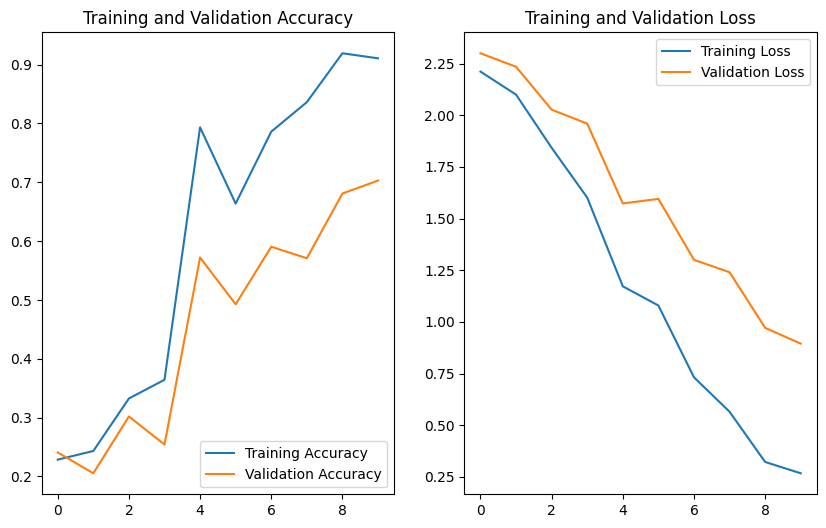

In [31]:
plot_acc_loss(train_acc_list,test_acc_list,train_loss_list,test_loss_list)

## 统计分析

In [32]:

predict_pro_array,predict_array,label_array = get_predict_score(text_cnn, test_dl)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00306469, 0.01608848, 0.1413054 , 0.00235254, 0.27076247],
       dtype=float32),
 array([7, 7, 7, 7, 7]),
 array([7, 7, 7, 7, 7]))

### 分类报告

- Precision（精确率）：预测为正类中真正正类的比例
- Recall（召回率）：真正正类中被预测为正类的比例  
- F1-score：精确率和召回率的调和平均
- Support：每个类别的样本数量

In [33]:

print(classification_report(label_array, predict_array,digits=3,target_names=name_list))

                  precision    recall  f1-score   support

         ACCOUNT      0.548     0.963     0.698       190
CANCELLATION_FEE      0.400     0.308     0.348        26
         CONTACT      0.667     0.038     0.073        52
        DELIVERY      0.955     0.689     0.800        61
        FEEDBACK      0.949     0.638     0.763        58
         INVOICE      1.000     0.667     0.800        60
      NEWSLETTER      1.000     0.294     0.455        34
           ORDER      0.899     0.620     0.734       129
         PAYMENT      0.500     0.690     0.580        58
          REFUND      0.782     0.925     0.847        93
SHIPPING_ADDRESS      0.959     0.825     0.887        57

        accuracy                          0.703       818
       macro avg      0.787     0.605     0.635       818
    weighted avg      0.769     0.703     0.684       818



### 混淆矩阵

- 对角线：预测正确的数量
- 非对角线：预测错误的情况
- 颜色越深，数量越多

In [34]:

cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[183,   0,   1,   0,   0,   0,   0,   2,   4,   0,   0],
       [ 14,   8,   0,   0,   0,   0,   0,   1,   2,   1,   0],
       [ 44,   0,   2,   0,   0,   0,   0,   0,   6,   0,   0],
       [  2,   2,   0,  42,   0,   0,   0,   0,  15,   0,   0],
       [ 12,   0,   0,   0,  37,   0,   0,   1,   3,   5,   0],
       [  1,   1,   0,   2,   2,  40,   0,   1,   0,  13,   0],
       [ 17,   3,   0,   0,   0,   0,  10,   2,   2,   0,   0],
       [ 37,   3,   0,   0,   0,   0,   0,  80,   7,   2,   0],
       [ 16,   1,   0,   0,   0,   0,   0,   0,  40,   1,   0],
       [  2,   1,   0,   0,   0,   0,   0,   1,   1,  86,   2],
       [  6,   1,   0,   0,   0,   0,   0,   1,   0,   2,  47]])

<Axes: >

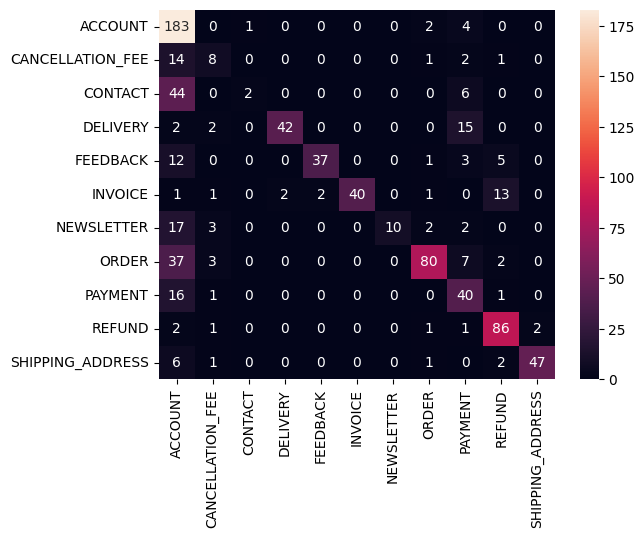

In [35]:
sns.heatmap(cnf_matrix, annot=True, fmt='g',xticklabels=name_list,yticklabels=name_list)

# 单条文本预测


In [36]:
name_list = le.classes_
import json
name_list

array(['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK',
       'INVOICE', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUND',
       'SHIPPING_ADDRESS'], dtype=object)

In [37]:
pd_data.head()

,utterance,intent,category,tags,len,label
0,I have to submit some feedback for your company,review,FEEDBACK,B,9,4
1,how to check when my item is going to arrive?,delivery_period,DELIVERY,BI,10,3
2,I need assistance to remove an item,change_order,ORDER,B,7,7
3,could you help me reporting registration issues?,registration_problems,ACCOUNT,BIMP,7,0
4,what do I have to do to buy something?,place_order,ORDER,BI,9,7


In [38]:

def predict(one_text,tokenizer, model):
  one_result = tokenizer(one_text,padding='max_length', max_length=max_len, truncation=True, return_tensors="pt")
  # print(one_result)
  one_ids = one_result.input_ids[0]
  one_ids = one_ids.unsqueeze(0).to(device)

  # 使用模型进行预测
  with torch.no_grad():
      output = model(one_ids)
  # print(output)
  # 计算预测概率
  pred_score = nn.functional.softmax(output[0], dim=0)
  pred_score = torch.max(pred_score).cpu().numpy()

  # 获取预测结果
  pred_index = torch.argmax(output, dim=1).item()
  pred_label = name_list[pred_index]

  print(f"predict class name : {pred_label} \npredict score : {pred_score}")
  print(pred_index)
  # 转为json字符串格式
  result_dict = {'pred_score':str(pred_score),'pred_index':str(pred_index),'pred_label':pred_label }
  result_json = json.dumps(result_dict)

  return result_json

eg_text = 'I need assistance to create an online account	'
# eg_text = 'i feel so sad'
predict(eg_text,tokenizer,text_cnn)

predict class name : ACCOUNT 
predict score : 0.9829548001289368
0


'{"pred_score": "0.9829548", "pred_index": "0", "pred_label": "ACCOUNT"}'

**🔮 单条预测详解：**

**预测流程：**
1. **文本预处理**：和训练时完全一样的tokenize过程
2. **模型推理**：`torch.no_grad()`关闭梯度计算，节省内存
3. **概率计算**：softmax将输出转换为概率分布
4. **结果解析**：找到最大概率对应的类别

**输出解释：**
- `pred_label`：预测的意图类别名称
- `pred_score`：预测的最高概率（置信度）
- `pred_index`：类别对应的数字编号


# 🎉 总结

这个TextCNN客户意图识别系统完成了：

✅ **数据处理**：从原始CSV到模型可用格式  
✅ **模型构建**：多卷积核捕获不同n-gram特征  
✅ **训练优化**：Adam优化器+CrossEntropy损失  
✅ **性能评估**：准确率、F1-score、混淆矩阵  
✅ **实际应用**：单条文本预测API

**适用场景：**
- 客服智能分流
- 邮件自动分类  
- 用户反馈分析
- 聊天机器人意图理解

**改进方向：**
- 尝试更大的预训练模型（BERT、RoBERTa）
- 增加数据增强技术
- 调整网络结构和超参数
- 添加注意力机制

现在你也可以搭建自己的客户意图识别系统啦！🚀